In [312]:
import torch.nn as nn
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
    #    x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
     #   x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [ ]:
    ### Dimension setup ###
    config = yaml.load(open(args.conf_dir, 'r'), Loader=yaml.FullLoader)
    sel_sensors = config['articulatory_data']['sel_sensors']
    sel_dim = config['articulatory_data']['sel_dim'] 
    delta = config['articulatory_data']['delta']
    d = 3 if delta == True else 1
    D_in = len(sel_sensors)*len(sel_dim)*d
    D_out = 41
    
    ### Model setup ###
    n_cnn_layers = config['deep_speech_setup']['n_cnn_layers']
    n_rnn_layers = config['deep_speech_setup']['n_rnn_layers']    
    rnn_dim = config['deep_speech_setup']['rnn_dim']
    stride = config['deep_speech_setup']['stride']
    dropout = config['deep_speech_setup']['dropout']
    
    ### Training setup ###
    learning_rate = config['deep_speech_setup']['learning_rate']
    batch_size = config['deep_speech_setup']['batch_size']
    epochs = config['deep_speech_setup']['epochs']
    early_stop = config['deep_speech_setup']['early_stop']
    patient = config['deep_speech_setup']['patient']
    normalize_input = config['articulatory_data']['normalize_input']
    train_out_folder = os.path.join(exp_output_folder, 'training')
    if not os.path.exists(train_out_folder):
        os.makedirs(train_out_folder)
    results = os.path.join(train_out_folder, test_SPK + '_train.txt')
    
    ### Model training ###
    random_sin_noise_inj = config['data_augmentation']['random_sin_noise_inj']
    random_rotate_apply = config['data_augmentation']['random_rotate']
    random_noise_add = config['data_augmentation']['random_noise']
    random_time_mask = config['data_augmentation']['random_time_mask']
    random_freq_mask = config['data_augmentation']['random_freq_mask']
    

In [14]:
class ema_random_rotate(object):
    def __init__(self, prob = 0.5, angle_range = [-np.pi/18, np.pi/18]):
        self.prob = prob
        self.angle_range = angle_range
        
    def translation(self, EMA_2D):

        sensor_centroid = np.mean(EMA_2D, axis = 0)
        shape_centroid = np.mean(np.reshape(sensor_centroid, (-1, 2)), axis = 0)
        shape_centroid_duplicated = np.resize(shape_centroid, (1,EMA_2D.shape[1]))
        EMA_translated = EMA_2D - shape_centroid_duplicated
        return EMA_translated 
        
    def rotation(self, EMA, angle):
        import math
        rotate_matrix = np.matrix([[math.cos(angle), math.sin(angle)], [-math.sin(angle), math.cos(angle)]])
        EMA_rotated = np.zeros((EMA.shape[0], EMA.shape[1]))

        for i in range(int((EMA.shape[1])/2)):
            sensor_2D = EMA[:,[2*i, 2*i+1]]
            sensor_2D_rotated = np.dot(sensor_2D, rotate_matrix)
            EMA_rotated[:,[2*i, 2*i+1]] = sensor_2D_rotated
        return EMA_rotated        
   
    def __call__(self, ema):
        if random.random() < self.prob:
            ema = self.translation(ema)
            angle = (random.randint(self.angle_range[0], self.angle_range[1])*np.pi)/180
            ema = self.rotation(ema, angle)                      
        return ema

In [352]:
import os
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
from utils.models import RegressionLoss
from utils.models import save_model
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from utils.utils import EarlyStopping, IterMeter, data_processing_DeepSpeech
import torch.nn.functional as F

import random
from utils.transforms import apply_delta_deltadelta, Transform_Compose
from utils.utils import EarlyStopping, IterMeter, data_processing_DeepSpeech
import matplotlib.pyplot as plt
import numpy as np
from utils.transforms import apply_MVN
import torch.nn as nn
from utils.utils import data_processing_DeepSpeech, GreedyDecoder
from jiwer import wer
import yaml
import torchaudio

In [84]:
class ema_sin_noise(object):
    def __init__(self, prob = 0.5, noise_energy_ratio = 0.1, noise_freq  = 40, fs=100):
        self.prob = prob
        self.noise_energy_ratio = noise_energy_ratio
        self.noise_freq = noise_freq
        self.fs = fs
        
    def noise_injection(self, ema, noise_energy_ratio, noise_freq, fs):

        x = np.arange(ema.shape[0])
        sin_noise = torch.outer(torch.Tensor(np.sin(2 * np.pi * noise_freq * x / fs)), 
                                torch.abs(torch.Tensor(ema.mean(0)*noise_energy_ratio)))
        ema = torch.Tensor(ema) + sin_noise
        return ema
        
    def __call__(self, ema):
        if random.random() < self.prob:
            ema = self.noise_injection(ema, self.noise_energy_ratio, self.noise_freq, self.fs) 
        return ema

In [165]:
def data_processing_DeepSpeech(data, transforms = None):
    ema = []
    labels = []
    input_lengths = []
    label_lengths = []
    
    for file_id, x, y in data:
        if transforms is not None:
            x = transforms(x)

        ema.append(torch.FloatTensor(x))
        labels.append(y)
        input_lengths.append(x.shape[0] // 2)
        label_lengths.append(len(y))
        
    ema = torch.nn.utils.rnn.pad_sequence(ema, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)        
    
    return file_id, ema, labels, input_lengths, label_lengths

In [166]:
data_CV_path = 'current_exp/data_CV'
Test_SPK = 'F01'
data_CV_SPK = os.path.join(data_CV_path, Test_SPK)

tr = open(os.path.join(data_CV_SPK, 'train_data.pkl'), 'rb') 
va = open(os.path.join(data_CV_SPK, 'valid_data.pkl'), 'rb')        
train_dataset, valid_dataset = pickle.load(tr), pickle.load(va)

ema_dim = 8 # TT, TB, UL, LL--xz
D_in = 24
n_class = 41
D_out = 41

####
n_cnn_layers = 1
n_rnn_layers = 2    
rnn_dim = 512
stride = 2
dropout = 0.3

In [167]:
norm_transform = [apply_delta_deltadelta()]
norm_transforms_all = Transform_Compose(norm_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = norm_transforms_all))

EMA_all = {}
i = 0
for batch_idx, _data in enumerate(train_loader):
    file_id, EMA, labels, input_lengths, label_lengths = _data 
    ema = EMA[0][0].T
    EMA_all[i] = ema
    i+=1
    
EMA_block = np.concatenate([EMA_all[x] for x in EMA_all], 0)
EMA_mean, EMA_std  = np.mean(EMA_block, 0), np.std(EMA_block, 0)

In [168]:
train_transform = []
valid_transform = []

valid_transform.append(apply_delta_deltadelta())
valid_transform.append(apply_MVN(EMA_mean, EMA_std))

valid_transforms_all = Transform_Compose(valid_transform)
test_transforms_all = Transform_Compose(valid_transform)

train_transform.append(apply_delta_deltadelta())
train_transform.append(apply_MVN(EMA_mean, EMA_std))

#train_transforms_all = Transform_Compose(train_transform)

In [299]:
class ema_random_rotate(object):
    def __init__(self, prob = 0.5, angle_range = [-np.pi/18, np.pi/18]):
        self.prob = prob
        self.angle_range = angle_range
        
    def translation(self, EMA_2D):

        sensor_centroid = np.mean(EMA_2D, axis = 0)
        shape_centroid = np.mean(np.reshape(sensor_centroid, (-1, 2)), axis = 0)
        shape_centroid_duplicated = np.resize(shape_centroid, (1,EMA_2D.shape[1]))
        EMA_translated = EMA_2D - shape_centroid_duplicated
        return EMA_translated 
        
    def rotation(self, EMA, angle):
        import math
        rotate_matrix = np.matrix([[math.cos(angle), math.sin(angle)], [-math.sin(angle), math.cos(angle)]])
        EMA_rotated = np.zeros((EMA.shape[0], EMA.shape[1]))

        for i in range(int((EMA.shape[1])/2)):
            sensor_2D = EMA[:,[2*i, 2*i+1]]
            sensor_2D_rotated = np.dot(sensor_2D, rotate_matrix)
            EMA_rotated[:,[2*i, 2*i+1]] = sensor_2D_rotated
        return EMA_rotated        
   
    def __call__(self, ema):
        if random.random() < self.prob:
            ema = self.translation(ema)
            angle = (random.randint(self.angle_range[0], self.angle_range[1])*np.pi)/180
            ema = self.rotation(ema, angle)                      
        return ema

In [329]:

class ema_wav_length_match(object):
    '''
    scale ema according to wav
    '''
    def __call__(self, ema, wav):
        from scipy import ndimage
        scale_ratio = wav.shape[0] / ema.shape[0]
        ema_align = np.empty([wav.shape[0], ema.shape[1]])
        for i in range(ema.shape[1]):
            ema_align[:,i] = ndimage.zoom(ema[:,i], scale_ratio)
        return ema_align, wav

class ema_random_scale(object):
    def __init__(self, prob = 0.5, scale = 0.8):
        self.prob = prob
        self.scale = scale     
   
    def __call__(self, ema):
        from scipy import ndimage
        if random.random() < self.prob:
            ema_align = np.empty([round(ema.shape[0]*scale), ema.shape[1]])  
            for i in range(ema.shape[1]):
                ema_align[:,i] = ndimage.zoom(ema[:,i], self.scale)
        return ema

In [428]:
class ema_time_mask(object):
    def __init__(self, prob = 0.5, mask_num = 20):
        self.prob = prob
        self.mask_num = mask_num
           
    def __call__(self, ema):
        masking = torchaudio.transforms.TimeMasking(time_mask_param=self.mask_num)
        if random.random() < self.prob:
            ema = masking(torch.Tensor(ema.T))                 
        return ema.T
        
        
class ema_freq_mask(object):
    def __init__(self, prob = 0.5, mask_num = 20):
        self.prob = prob
        self.mask_num = mask_num
           
    def __call__(self, ema):
        masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=self.mask_num)
        if random.random() < self.prob:
            ema = masking(torch.Tensor(ema.T))                     
        return ema.T

In [429]:
noise = False
rotate = False
scale = False
time_mask = False
freq_mask = True

In [442]:
##### Noise injection
train_transform = []
if noise == True:
    ratio = 0.5
    noise_energy_ratio = 0.05
    noise_freq = 20
    fs = 100
    train_transform.append(ema_sin_noise(ratio, noise_energy_ratio, noise_freq, fs)) 
    
if rotate == True:
    ratio = 0.5
    angle = [-30, 30]
    train_transform.append(ema_random_rotate(ratio,  angle)) 
    
if scale == True:
    ratio = 0.5
    scale = 0.8
    train_transform.append(ema_random_scale(ratio, scale)) 
    
if time_mask == True:
    ratio = 1
    mask_num = 10
    train_transform.append(ema_time_mask(ratio, mask_num))
    
if freq_mask == True:
    ratio = 1
    mask_num = 8
    train_transform.append(ema_freq_mask(ratio, mask_num))

In [443]:
train_transforms_all = Transform_Compose(train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=lambda x: data_processing_DeepSpeech(x, transforms = train_transforms_all))

In [444]:
for batch_idx, _data in enumerate(train_loader):
    file_id, ema, labels, input_lengths, label_lengths = _data 

In [445]:
print(ema.shape)
print(ema[0,0].shape)

torch.Size([1, 1, 8, 213])
torch.Size([8, 213])


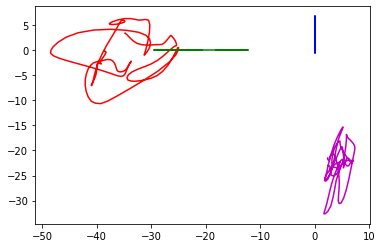

In [446]:
MV = ema[0,0].cpu().numpy()
plt.plot(MV[0,:], MV[1,:], 'r', MV[2,:], MV[3,:], 'g', MV[4,:], MV[5,:], 'b', MV[6,:], MV[7,:], 'm')

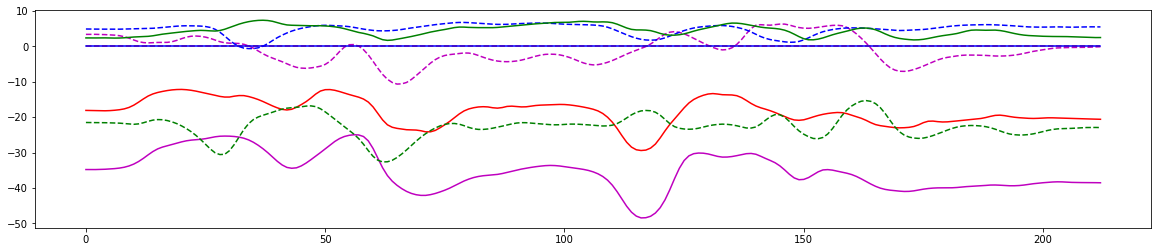

In [447]:
MV = ema[0,0].cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.plot(MV[0,:], 'm', label = "TB_x")
plt.plot(MV[1,:], 'm--', label = "TB_z")
plt.plot(MV[2,:], 'r', label = "TT_x")
plt.plot(MV[3,:], 'r--', label = "TT_z")
plt.plot(MV[4,:], 'b', label = "UL_x")
plt.plot(MV[5,:], 'b--', label = "UL_z")
plt.plot(MV[6,:], 'g', label = "LL_x")
plt.plot(MV[7,:], 'g--', label = "LL_z")